In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import scipy.optimize as spo
plt.style.use('seaborn')

from datetime import datetime as dt

#### Unimportant Warnings

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

#### Custom Files

In [3]:
from data_io import DataIO # Custom IO file

# Input/Output of RGA and Temperature Data

In [4]:
Path = "/home/ael59/project/run_data/2020_11_09/" # data file path

In [5]:
IO = DataIO(Path)

In [6]:
IO.Unzip()

In [7]:
RGA_Data = IO.GetRGAData()

In [8]:
Temp = IO.GetTemperatureData()

In [9]:
#data.to_hdf(p+"10_19_rga_2020.h5", key='data')

In [10]:
RGA_Data.sort_values(by=['Datetime', 'Mass'], inplace=True)
#RGA_Data

In [11]:
Temp.sort_values(by='Datetime', inplace=True)
#Temp

### Times

In [12]:
# Starting RGA Time
rga_start = RGA_Data['Datetime'].sort_values().unique()[0]
#rga_start

In [13]:
# Starting temperature time
temps_start = Temp['Datetime'].sort_values().unique()[0]
#temps_start

In [14]:
# Find the EARLIEST time to calculate timedeltas from.
if rga_start < temps_start:
    start_datetime = rga_start
else:
    start_datetime = temps_start

In [15]:
#start_datetime

In [16]:
temp_times = (Temp['Datetime'] - start_datetime)/np.timedelta64(1, 's')
#temp_times

In [17]:
# Separate by mass
H2_data = RGA_Data[RGA_Data['Mass'] == 2.0]
H2O_data = RGA_Data[RGA_Data['Mass'] == 18.0]
N2_data = RGA_Data[RGA_Data['Mass'] == 28.0]
O2_data = RGA_Data[RGA_Data['Mass'] == 32.0]
CO2_data = RGA_Data[RGA_Data['Mass'] == 44.0]

In [18]:
rga_times = (RGA_Data['Datetime'].unique() - start_datetime)/np.timedelta64(1, 's')
H2_times = (H2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
H2O_times = (H2O_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
N2_times = (N2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
O2_times = (O2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
CO2_times = (CO2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')

In [19]:
#CO2_times

### Temperature Interpolation

In [20]:
#pd.to_numeric(Temp['CH1'])

In [21]:
CO2_ch1_lerp = np.interp(CO2_times, temp_times, pd.to_numeric(Temp['CH1']))
CO2_ch2_lerp = np.interp(CO2_times, temp_times, pd.to_numeric(Temp['CH2']))

### Final Data Frames

In [22]:
## Build CO2 final data frame
CO2_final_data = pd.DataFrame(data=CO2_times)
CO2_final_data.columns = ['Exp_Time']
# Torr now
CO2_final_data['CO2_Pressure'] = CO2_data['Pressure']
# Celsius to Kelvin
CO2_final_data['ch1_lerp'] = CO2_ch1_lerp + 273.2
CO2_final_data['ch2_lerp'] = CO2_ch2_lerp + 273.2
CO2_final_data['temp_est'] = (CO2_final_data['ch1_lerp'] + CO2_final_data['ch2_lerp'])/2.0
#CO2_final_data

In [23]:
CO2_final_data.sort_values(by='Exp_Time', inplace=True)
#CO2_final_data

### Curve Fitting
$$p(t,T) = A\cdot \exp\left(-\frac{b}{T}\right)\cdot\exp\left(-c\cdot t\cdot \exp\left(-\frac{b}{T}\right)\right)$$

In [24]:
def pressure_fit(tT, A, b, c):
    # (k,M) array if there are k predictors
    factor = np.exp(-1.0*b/tT[1])
    return A * factor * np.exp(-1.0*c*tT[0]*factor)

In [25]:
#O2_jump1 = O2_final_data[O2_final_data['Datetime'].between(51000, 65000)]

In [26]:
jump1_bounds = [51000, 64600]
jump2_bounds = [64400, 89500]
jump3_bounds = [90000, 110200]
jump4_bounds = [110200, 150000]
CO2_params = [7, 5900, 800]

In [27]:
def jump_analysis(bounds, params):
    """Output the time, pressure data, and fit values for one CO2 jump defined
    by the bounds.
    
    Arguments
    bounds: a two-element list of [lower bound, upper bound]"""

    jump_table = CO2_final_data[CO2_final_data['Exp_Time'].between(bounds[0], bounds[1])]
    jump_time_start = jump_table['Exp_Time'].unique()[0]
    jump_table['Jump_Time'] = jump_table['Exp_Time'] - jump_time_start
    time_temp_vals = jump_table[['Jump_Time', 'temp_est']].T.to_numpy()
    fit_jump = jump_table['CO2_Pressure'].to_numpy()
    popt, pcov = spo.curve_fit(pressure_fit, time_temp_vals, fit_jump, p0=params, maxfev=100000)
    jump_fits = pressure_fit(time_temp_vals, popt[0], popt[1], popt[2])
    
    return jump_table['Exp_Time'], jump_table['CO2_Pressure'], jump_fits, popt, pcov, time_temp_vals

In [28]:
CO2_jump1_out = jump_analysis(jump1_bounds, CO2_params)
CO2_jump2_out = jump_analysis(jump2_bounds, CO2_params)
CO2_jump3_out = jump_analysis(jump3_bounds, CO2_params)
CO2_jump4_out = jump_analysis(jump4_bounds, CO2_params)

/gpfs/loomis/project/david_moore/ael59/conda_envs/nexo/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/gpfs/loomis/project/david_moore/ael59/conda_envs/nexo/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/gpfs/loomis/project/david_moore/ael59/conda_envs/nexo/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [29]:
CO2_jump4_out[3]

array([2.80866994e-01, 4.80893383e+03, 3.25754357e+01])

In [30]:
CO2_Ea_guesses = np.array([5750, 5800, 5820, 5821, 5822, 5823, 5824, 5825, 5850, 5875, 5900])
CO2_jump4_guessfits = [pressure_fit(CO2_jump4_out[5], CO2_jump4_out[3][0], guess, CO2_jump4_out[3][2]) for guess in CO2_Ea_guesses]

### Plotting

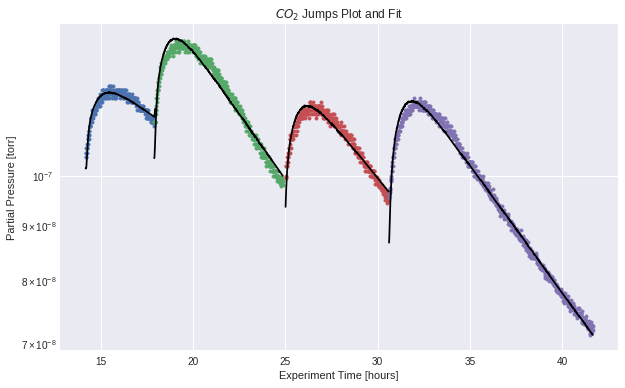

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(CO2_jump1_out[0]/3600, CO2_jump1_out[1], marker='.')
ax.plot(CO2_jump1_out[0]/3600, CO2_jump1_out[2], color='black')
ax.scatter(CO2_jump2_out[0]/3600, CO2_jump2_out[1], marker='.')
ax.plot(CO2_jump2_out[0]/3600, CO2_jump2_out[2], color='black')
ax.scatter(CO2_jump3_out[0]/3600, CO2_jump3_out[1], marker='.')
ax.plot(CO2_jump3_out[0]/3600, CO2_jump3_out[2], color='black')
ax.scatter(CO2_jump4_out[0]/3600, CO2_jump4_out[1], marker='.')
ax.plot(CO2_jump4_out[0]/3600, CO2_jump4_out[2], color='black')
#for idx, guess in enumerate(CO2_Ea_guesses):
#    ax.plot(CO2_jump4_out[0]/3600, CO2_jump4_guessfits[idx], label='Ea = {}'.format(guess))
ax.set_ylabel('Partial Pressure [torr]')
ax.set_xlabel('Experiment Time [hours]')
ax.set_title('$CO_2$ Jumps Plot and Fit')
#ax.legend()
ax.set_yscale('log')
fig.savefig('images/co2_4_fit_2020_11_09.png', dpi=144)

plt.show()

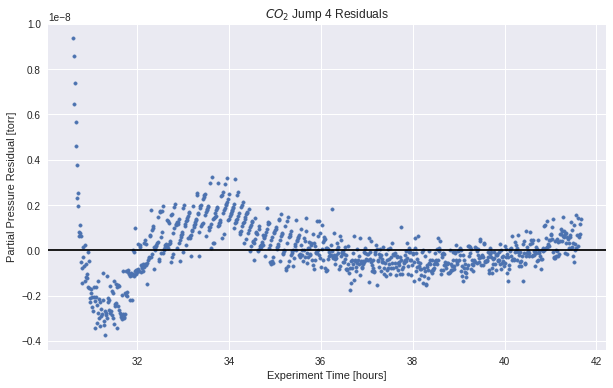

In [32]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(CO2_jump4_out[0]/3600, CO2_jump4_out[1] - CO2_jump4_out[2], marker='.')
ax.set_ylabel('Partial Pressure Residual [torr]')
ax.set_xlabel('Experiment Time [hours]')
ax.axhline(color='k')
ax.set_title('$CO_2$ Jump 4 Residuals')
#ax.set_yscale('log')
fig.savefig('images/co2_4_resid_2020_11_09.png', dpi=144)

plt.show()

In [33]:
CO2_data['Pressure'].iloc[np.array(CO2_times.between(50000,110000))]

1280802    1.070000e-07
5141738    1.080000e-07
2552255    1.060000e-07
3812807    1.070000e-07
4028845    1.070000e-07
               ...     
4766149    9.580000e-08
5204171    9.550000e-08
5376605    9.440000e-08
434488     9.490000e-08
145116     9.600000e-08
Name: Pressure, Length: 1447, dtype: float64

### Finding the Bounds of Each Jump

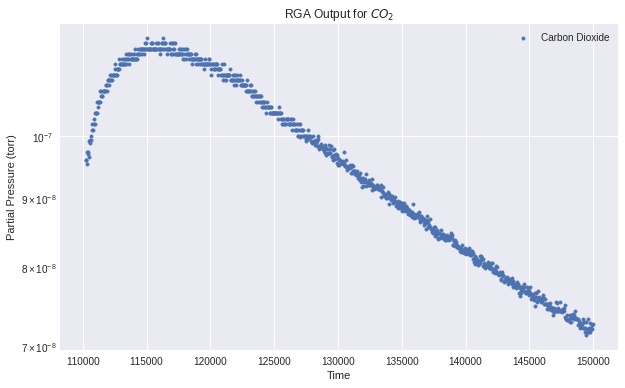

In [34]:
bnds = [110200, 150000]

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(CO2_times.iloc[np.array(CO2_times.between(bnds[0],bnds[1]))],
           CO2_data['Pressure'].iloc[np.array(CO2_times.between(bnds[0],bnds[1]))], marker='.', label='Carbon Dioxide')
ax.set_title('RGA Output for $CO_2$')
ax.set_xlabel('Time')
ax.set_ylabel('Partial Pressure (torr)')
ax.legend()
ax.set_yscale('log')

plt.show()

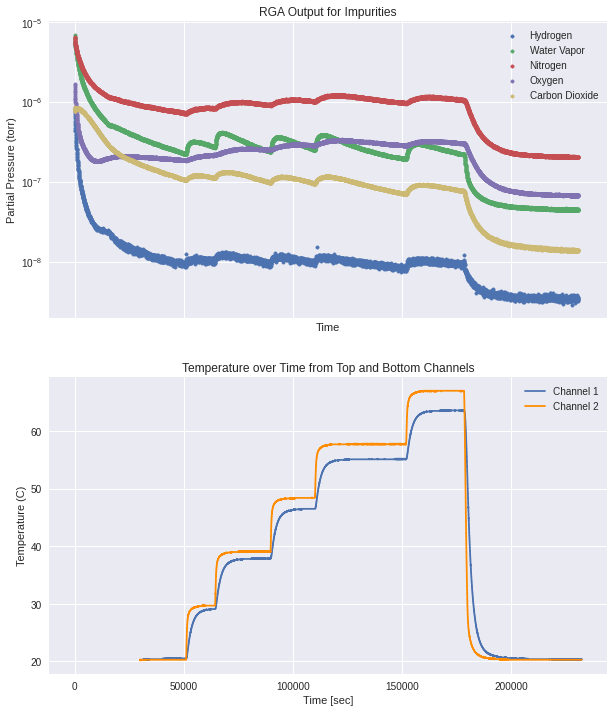

In [35]:
fig, ax = plt.subplots(figsize=(10,12),  nrows = 2, sharex=True)
ax[0].scatter(H2_times, H2_data['Pressure'], marker='.', label='Hydrogen')
ax[0].scatter(H2O_times, H2O_data['Pressure'], marker='.', label='Water Vapor')
ax[0].scatter(N2_times, N2_data['Pressure'], marker='.', label='Nitrogen')
ax[0].scatter(O2_times, O2_data['Pressure'], marker='.', label='Oxygen')
ax[0].scatter(CO2_times, CO2_data['Pressure'], marker='.', label='Carbon Dioxide')
ax[0].set_title('RGA Output for Impurities')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Partial Pressure (torr)')
ax[0].legend()
ax[0].set_yscale('log')

ax[1].plot(temp_times, pd.to_numeric(Temp['CH1']), label='Channel 1')
ax[1].plot(temp_times, pd.to_numeric(Temp['CH2']), label='Channel 2', color='darkorange')
ax[1].set_title('Temperature over Time from Top and Bottom Channels')
ax[1].set_xlabel('Time [sec]')
ax[1].set_ylabel('Temperature (C)')
ax[1].legend()

fig.savefig('plot_out_2020_11_09.png', dpi=300)
plt.show()

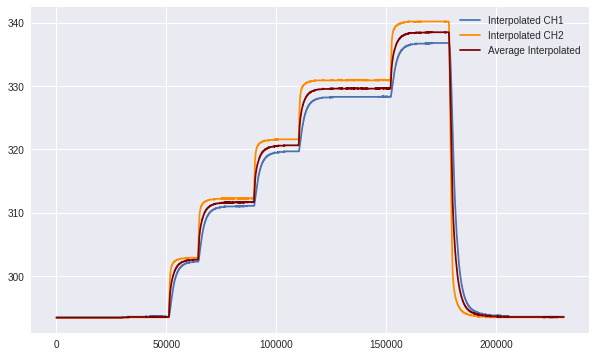

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(CO2_final_data['Exp_Time'], CO2_final_data['ch1_lerp'], label='Interpolated CH1')
ax.plot(CO2_final_data['Exp_Time'], CO2_final_data['ch2_lerp'], label='Interpolated CH2', color='darkorange')
ax.plot(CO2_final_data['Exp_Time'], CO2_final_data['temp_est'], label='Average Interpolated', color='maroon')
ax.legend()

plt.show()

In [37]:
#IO.RemoveZipDir()